# ⚡ Ejercicio 2.2: Paralelización

**Módulo 2: Patrones Multi-Agente**  
**Tiempo estimado**: 12 minutos  
**Ejercicio**: 2.2

---

## 🎯 Objetivos de Aprendizaje

1. ✅ Usar Send() API para fan-out
2. ✅ Ejecutar agentes en paralelo
3. ✅ Agregar resultados de múltiples agentes
4. ✅ Medir mejoras de performance


In [1]:
# ╔════════════════════════════════════════════════════════════╗
# ║  📋 SETUP Y VERIFICACIÓN                                  ║
# ╚════════════════════════════════════════════════════════════╝

%pip install -q langgraph langchain-openai python-dotenv

import os, sys
from dotenv import load_dotenv
sys.path.append(os.path.abspath('../..'))
load_dotenv()

print('='*50)
print('   SETUP VERIFICATION')
print('='*50)
print(f"✅ Python {sys.version.split()[0]}")
print(f"{'✅' if os.getenv('OPENAI_API_KEY') else '❌'} OpenAI API Key")
print(f"\n🎬 Ready!\n")

Note: you may need to restart the kernel to use updated packages.
   SETUP VERIFICATION
✅ Python 3.13.7
✅ OpenAI API Key

🎬 Ready!



## 💬 SCRIPT

> "Ejercicio 2.2: Análisis paralelo.
> 3 analistas trabajan AL MISMO TIEMPO.
> Esto es MUCHO más rápido que secuencial."

In [2]:
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send

class AnalysisState(TypedDict):
    document: str
    sentiment: str
    entities: list
    summary: str
    final_report: str

llm = ChatOpenAI(model='gpt-4o-mini')
print('✅ Setup')

✅ Setup


/tmp/ipykernel_258005/3790505162.py:4: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [3]:
# Analistas paralelos

def sentiment_analyst(state):
    print('🎭 Analizando sentimiento...')
    result = llm.invoke(f'Sentimiento (Positivo/Negativo/Neutral): {state["document"][:200]}')
    return {'sentiment': result.content}

def entity_analyst(state):
    print('👤 Extrayendo entidades...')
    result = llm.invoke(f'Extrae personas y organizaciones de: {state["document"][:200]}')
    return {'entities': result.content.split(',')}

def summary_analyst(state):
    print('📝 Generando resumen...')
    result = llm.invoke(f'Resume en una oración: {state["document"][:200]}')
    return {'summary': result.content}

print('✅ Analistas definidos')

✅ Analistas definidos


In [4]:
# Fan-out paralelo

def fan_out(state):
    '''Dispara los 3 analistas EN PARALELO'''
    return [
        Send('sentiment', state),
        Send('entities', state),
        Send('summary', state)
    ]

def aggregate(state):
    '''Combina todos los análisis'''
    report = f'''REPORTE FINAL:
    Sentimiento: {state.get("sentiment", "N/A")}
    Entidades: {state.get("entities", [])}
    Resumen: {state.get("summary", "N/A")}
    '''
    return {'final_report': report}

print('✅ Fan-out y aggregator definidos')

✅ Fan-out y aggregator definidos


In [15]:
# Construir grafo paralelo

graph = StateGraph(AnalysisState)
graph.add_node('fan_out', fan_out)
graph.add_node('sentiment', sentiment_analyst)
graph.add_node('entities', entity_analyst)
graph.add_node('summary', summary_analyst)
graph.add_node('aggregate', aggregate)

# Fan-out desde START
graph.add_conditional_edges(START, fan_out)

# Fan-in a aggregate
graph.add_edge('fan_out', 'fan_out')
graph.add_edge('sentiment', 'aggregate')
graph.add_edge('entities', 'aggregate')
graph.add_edge('summary', 'aggregate')
graph.add_edge('aggregate', END)

app = graph.compile()
print('✅ Grafo paralelo compilado')

✅ Grafo paralelo compilado


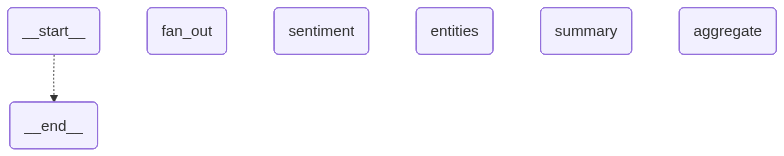

In [16]:
from IPython.display import Image, display
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
# 🎬 DEMO: Performance paralelo

import time

doc = ''' 

El tren hacia Oaxaca partió al amanecer, con un rumor metálico que parecía anunciar algo más que un simple desplazamiento. En el vagón, tres viajeros compartían asiento y destino, aunque no lo sabían: Elena, Daniel y Sofía.

Elena miraba por la ventana con una sonrisa que apenas cabía en su rostro. Era su primer viaje sola después de años dedicados al trabajo y la familia. “Por fin”, pensó, “por fin puedo escuchar el sonido del mundo sin que nadie me llame por mi nombre”. Para ella, el viaje era una promesa: los colores, los mercados, los olores de mole y mezcal que imaginaba eran una libertad recién estrenada. Cada kilómetro que el tren avanzaba era un peso menos sobre sus hombros.

Daniel, en cambio, observaba su reflejo en el vidrio con una mezcla de ansiedad y cansancio. Viajaba por trabajo, obligado a asistir a una conferencia que no le interesaba. Mientras Elena soñaba con horizontes, él repasaba mentalmente su presentación, temiendo no estar a la altura. “Todos van a notar que no quiero estar ahí”, se decía. El traqueteo del tren no le resultaba liberador, sino monótono, como un recordatorio de su falta de elección. Le molestaba el sol que se filtraba por la ventana y la conversación alegre de los demás pasajeros. Todo en ese viaje le parecía un ruido innecesario.

Sofía, sentada frente a ambos, guardaba silencio. Sostenía una libreta entre las manos, donde intentaba escribir sin éxito. Había vuelto a Oaxaca después de muchos años, para despedirse de su abuela enferma. En cada curva del trayecto veía reflejos del pasado: la casa de adobe, los juegos bajo el guayabo, el olor del pan dulce recién horneado. La nostalgia le apretaba el pecho como un nudo imposible de soltar. “No sé si estoy lista para verla”, pensó, mientras el paisaje se volvía más verde y los recuerdos más nítidos.

Cuando el tren llegó a su destino, los tres bajaron sin cruzar palabra. Para Elena, el aire olía a promesa. Para Daniel, a obligación. Para Sofía, a despedida.
El mismo viaje, tres corazones distintos. Porque ningún destino es igual cuando lo habitan emociones diferentes.
'''

print('='*60)
print('🚀 EJECUCIÓN PARALELA')
print('='*60)

start = time.time()
result = app.invoke({'document': doc})
elapsed = time.time() - start

print(f'\n⏱️ Tiempo: {elapsed:.2f}s')
print(f'\n{result["final_report"]}')
print('\n💡 Los 3 análisis se ejecutaron AL MISMO TIEMPO')

🚀 EJECUCIÓN PARALELA
🎭 Analizando sentimiento...
👤 Extrayendo entidades...
📝 Generando resumen...

⏱️ Tiempo: 2.03s

REPORTE FINAL:
    Sentimiento: El sentimiento del texto es **Neutral**. Aunque se describe el partimiento del tren y se menciona a los viajeros, no hay una carga emocional clara que denote un sentimiento positivo o negativo. Se presenta una situación de manera descriptiva sin mostrar juicios o emociones intensas.
    Entidades: ['En el fragmento proporcionado', ' se pueden extraer las siguientes personas y organizaciones:\n\n**Personas:**\n1. Tres viajeros (sin nombres específicos en el texto).\n\n**Organizaciones:**\nNo se mencionan organizaciones específicas en el texto. \n\nSi necesitas información adicional o un análisis más detallado', ' házmelo saber.']
    Resumen: El tren hacia Oaxaca partió al amanecer, mientras tres viajeros compartían asiento y destino sin conocer el significado del viaje que los unía.
    

💡 Los 3 análisis se ejecutaron AL MISMO TIEMPO


---

## ✅ CHECKPOINT FINAL

- [ ] Código ejecuta sin errores
- [ ] Conceptos clave entendidos
- [ ] Listos para continuar

### 💬 PREGUNTA:
> "¿Alguna duda antes de continuar?"
